In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
import dadi 
import dadi.DFE as DFE

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [2]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.geomspace(1e-5,5e-3,20) #np.logspace(-0.5,2.5,25)
n = 1000
N = 10000
mu = 1.25e-8
cutoff = 2 # freq of 0.5%
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# for N=10,000 & gamma=-10, s=-0.0005

In [3]:
# s = -np.array([8e-5]) # gamma of 2, 20, 200 for N=10,000 & 4Ns
# for ig, g in enumerate(s):
#     with open('simfiles/ParameterFilesBottleneck.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
#     data[7] = 'FilePrefix: outfiles/Bottleneck{:.0e}\n'.format(-g)

#     with open('simfiles/ParameterFilesBottleneck.txt', 'w') as file:
#         file.writelines(data)
        
#     os.system("GSL_RNG_SEED=1004 GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesBottleneck.txt 1")

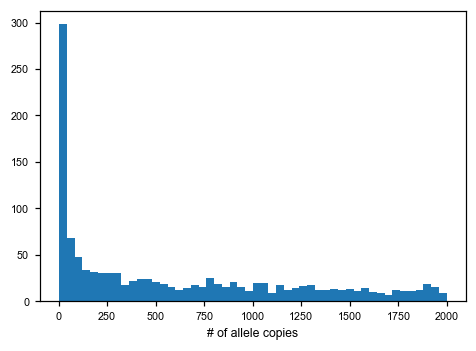

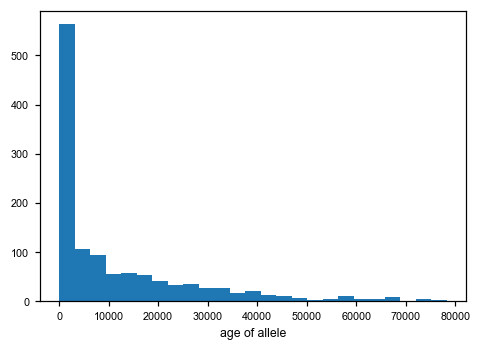

[]

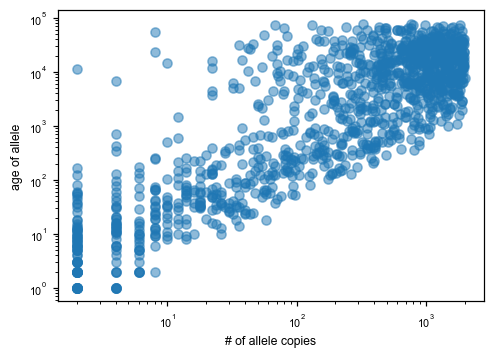

In [78]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/Bottleneck3e-05.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=1200)
Nc = np.concatenate((np.repeat(20000,80000),np.repeat(2000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1
df1['sXl'] = df1['Xl']*n 
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
plt.hist(df1['sXl'],50); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

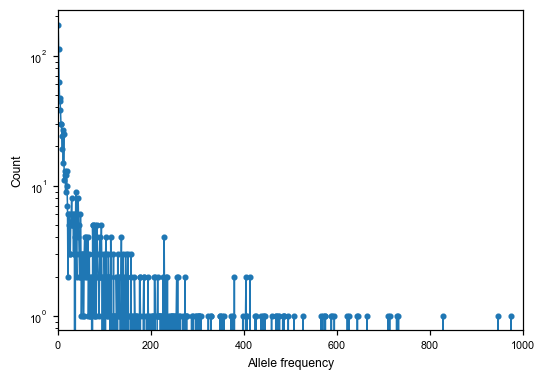

In [272]:
# counts, bins, _ = plt.hist(df1['sXl'],bins=2000,range=(0.5,2000.5))
fsbot = moments.Spectrum(np.histogram(df1['sXl'],bins=np.arange(0,n+2))[0],mask_corners=False)
moments.Plotting.plot_1d_fs(fsbot)

In [303]:
import warnings
warnings.filterwarnings("ignore")
# # moments.Inference.ll_multinom(fs,fsbot)
# # np.sum(-fs + fsbot*np.log(fs) - sp.special.gammaln(fsbot+1))
# moments.Inference.ll(fsbot.S()/fs.S()*fs,fsbot)

In [30]:
llfreqbin

[-6772936.112294777,
 -6772975.1022904655,
 -6773034.04813492,
 -6773123.164965771,
 -6773257.898684781,
 -6773461.606492329,
 -6773769.614366205,
 -6774235.361562928,
 -6774939.714612073,
 -6776005.104864094,
 -6777617.030934684,
 -6780056.86233046,
 -6783752.10949577,
 -6789353.970253158,
 -6797858.112761434,
 -6810795.39196704,
 -6830538.735749595,
 -6860809.597245043,
 -6907540.441795681,
 -6980398.127475488,
 -7095573.830744679,
 -7281029.677968645,
 -7586342.402123775,
 -8100040.267612852,
 -8975563.079184592,
 -10463628.397421738,
 -12963847.19237272,
 -17119417.955433846,
 -23826250.975091957,
 -33855887.12039141,
 -48517346.10451627,
 -69856817.80317934,
 -223720051.5654849,
 -247916642.76091123,
 -309794659.8989056,
 -308817172.0552287,
 -295387387.37043166,
 -301869017.1288454,
 -358159729.2615167,
 -443843305.4351764]

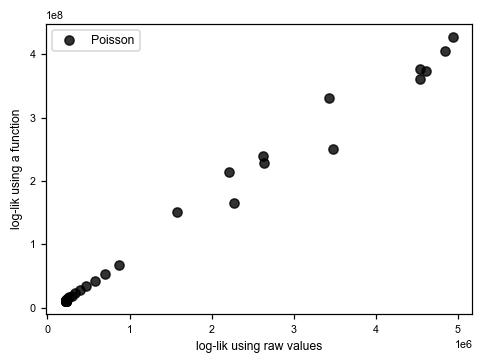

In [86]:
# llfreq = [np.sum(get_lp_xl(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqpois = [np.sum(get_lp_xl_pois(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqbin = [np.sum(get_lp_xl_bin(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
plt.scatter(llfreq, llfreqpois, color='k', alpha=0.8, label='Poisson'); plt.xlabel('log-lik using raw values'); plt.ylabel('log-lik using a function'); plt.legend()

In [91]:
# np.max(llfreqpois)-llfreqpois, np.max(llfreq) - llfreq


array([100.000, 131.826, 173.780, 229.087, 301.995])

In [83]:
sp.optimize.minimize_scalar(get_ll_freqchanging, args=({'nu': nu_func,'T':4.05, 'Nc0':Nc[0], 'dt_fac':0.0005, 'theta':1}, dat[:,5]), options={'xtol':1e-6}, bracket=(-5e-3,-1e-5))
sp.optimize.minimize_scalar(get_ll_freqagechanging, args=({'Nc':Nc}, dat[:,5], dat[:,3]), options={'xtol':1e-6}, bracket=(-5e-3,-1e-5))

N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9


     fun: 2467.294893134939
    nfev: 20
     nit: 16
 success: True
       x: -5.4828985450560764e-05

In [129]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
for ig, g in enumerate(gamma):
    ## unscaled probability - almost likelihood # original options: n, g, 2*Nc[::-1], ...
    up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 4.05, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9


In [139]:
# dat = df1.sample(frac=0.5).to_numpy(dtype='int64')
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.nanargmax(sin_onlyfreq)]*1e5, gamma[np.nanargmax(sin_onlyage)]*1e5)
mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=25,cutoff=2)
mle.std(axis=0)*1e5

-259.936878074525 -187.42039366662618


array([49.472, 35.526])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [ ]:
# sin_onlyfreq, gamma*1e5
get_bfq(sin_onlyfreq, gamma)[1]*0.5/get_bfq(sin_onlyfreq, gamma)[0], get_bfq(sin_onlyage, gamma)[1]*0.5/get_bfq(sin_onlyage, gamma)[0]

(0.0007434877309397413, 0.000999750356696217)

In [140]:
estfreq, estage = np.array([1.9235, 7.117, 18.99, 70.25, 259.93])*1e-5, np.array([2.667, 7.117, 26.33, 70.25, 307.78])*1e-5
sefreq, seage = np.array([0.579, 1.326, 1.44, 5.317, 49.472])*1e-5, np.array([0.887, 1.367, 2.387, 5.327, 35.526])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

(2e-06, 0.005)

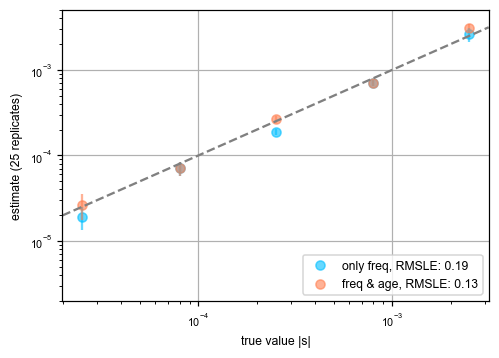

In [141]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid(); plt.ylim((2e-6,5e-3))

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

NameError: name 'densegrid' is not defined

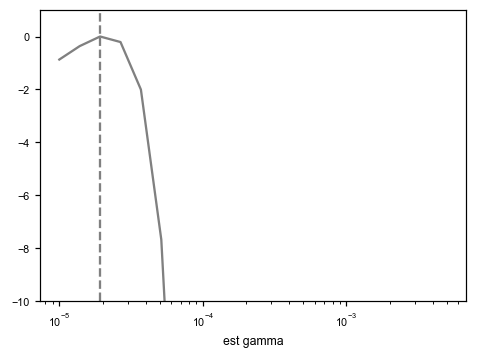

In [ ]:
plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'][0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
# plt.vlines(get_ci(sin_onlyage,gamma),ymin=-10.,ymax=0.,color='k',ls='-.')
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

2. Expansion.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of recent expansion 200 gens ago to 200k inds -> didn't work, too complex a scenario - changing to a simpler 4x expansion...)

In [169]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
s = -np.array([2.5e-5,2.5e-4,2.5e-3,8e-5,8e-4]) # gamma of 2, 20, 200 for N=10000 & 4Ns
for ig, g in enumerate(s):
    with open('simfiles/ParameterFilesExpansion.txt',"r") as file:
        data = file.readlines()

    data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
    data[7] = 'FilePrefix: outfiles/Expansion{:.0e}\n'.format(-g)

    with open('simfiles/ParameterFilesExpansion.txt', 'w') as file:
        file.writelines(data)
        
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesExpansion.txt 3".format(rng.integers(100496)))

GSL_RNG_TYPE=mrg
GSL_RNG_SEED=36520



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000025
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16006078

Total number of mutations = 20005374


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=50361
GSL_RNG_TYPE=mrg
GSL_RNG_SEED=59200



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.002500
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-03

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 15997875

Total number of mutations = 19997401


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=4624



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000080
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16002395

Total number of mutations = 20002639


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=88220



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000800
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-04

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16003032

Total number of mutations = 20002072


In [292]:
# gamma = -np.logspace(-0.5,2.5,30)
# 2 contains the 4x expansion from 10k to 40k, 3 contains the 10x expansion from 5k to 50k
df1 = pd.read_csv("outfiles/Expansion3e-05.3.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=6000)
# Nc = np.concatenate((np.repeat(10000,50000),np.repeat(40000,5000)))
Nc = np.concatenate((np.repeat(5000,80000),np.repeat(50000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1['sXl'] = df1['Xl']*1000
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],10); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],15); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

In [171]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
n = 1000
for ig, g in enumerate(gamma):
#     ## unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    # p_xa_s[g] = np.sum(up_xa_s[g], axis=0)
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 16.39, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative c

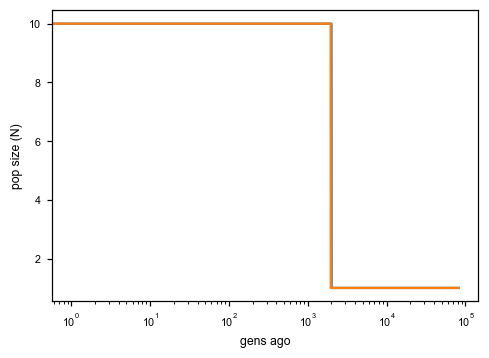

In [182]:
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
plt.plot([nu_func(t) for t in np.linspace(16.39,0,82000)]) # should align on top of real demography if unscaled by Nc[0]
# plt.imshow(up_xa_s[gamma[-1]],aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()

In [179]:
## inference procedure (plot the loglik surfaces)
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.argmax(sin_onlyfreq)]*1e4, gamma[np.argmax(sin_onlyage)]*1e4)
# mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
# mle.std(axis=0)*1e4
# plt.plot(mle[:,0],'o',alpha=0.9); plt.plot(mle[:,1],'o',alpha=0.6); plt.axhline(-5e-4,ls='--',color='grey')

-319.36503936014617 -500.0


array([-1.000, -1.566, -2.451, -3.837, -6.008, -9.406, -14.726, -23.056,
       -36.096, -56.512, -88.476, -138.519, -216.866, -339.527, -531.566,
       -832.223, -1302.933, -2039.881, -3193.650, -5000.000])

In [22]:
# -1412467.660*0.5/2630619535.047, -1958844.339*0.5/8753100490.378
# get_bfq(sin_onlyfreq, gamma)[1]*0.5/get_bfq(sin_onlyfreq, gamma)[0], get_bfq(sin_onlyage, gamma)[1]*0.5/get_bfq(sin_onlyage, gamma)[0]
print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])

-0.005 -0.005


In [470]:
# sin_onlyfreq, gamma*1e5
# -315544.716*0.5/7487071113.44, 1343653.57*0.5/9127767370.694
get_bfq(sin_onlyfreq, gamma), get_bfq(sin_onlyage, gamma)

In [125]:
estfreq, estage = np.array([2.67, 9.87, 26.33, 97.43, 259.9])*1e-5, np.array([1.0, 5.131, 13.69, 70.25, 259.9])*1e-5
sefreq, seage = np.array([4.544, 2., 2.764, 10.44, 47.11])*1e-5, np.array([3.022, 1.62, 3.3, 9.79, 45.15])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

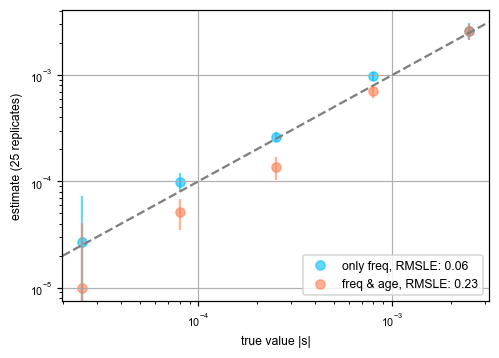

In [126]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid()

-1.0
-1.0


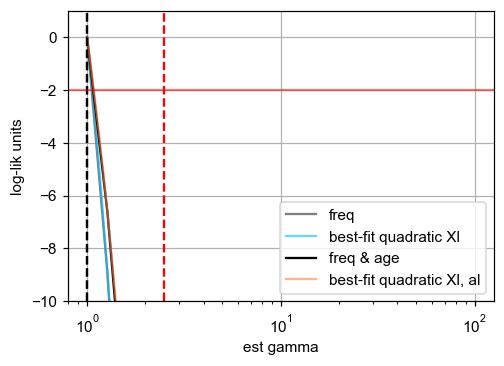

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'].iloc[0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

3. BottleneckpExpenasion.txt with point prob selection coefficient () and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, followed by exponential growth)

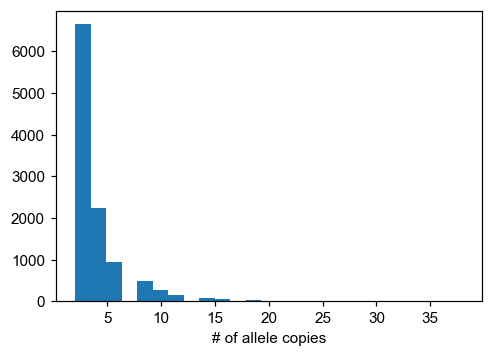

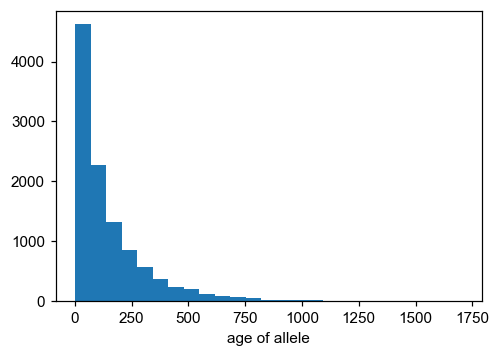

[]

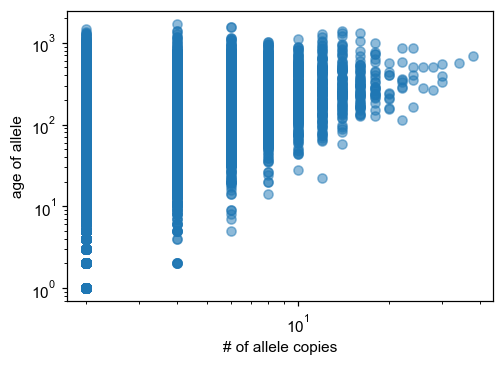

In [ ]:
df1 = pd.read_csv("PReFerSims/outfiles/BottleneckpExpansion10.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(10000,50000),np.repeat(2000,500),np.repeat(50000,3000)))/2
df1['sXl'] = df1['Xl']*n #rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
df1 
dat = df1.sample(frac=0.9).to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

[]

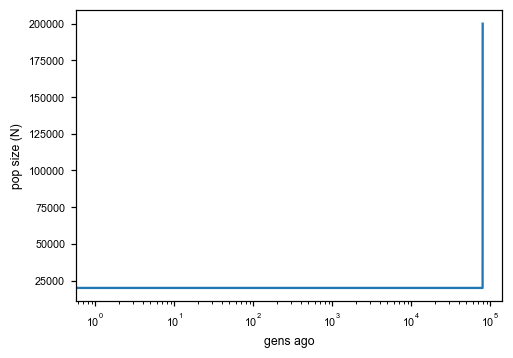

In [ ]:
# up_xa_s = {}
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()

In [ ]:
mle = get_boot_ci(gamma[:-1],p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
mle.mean(axis=0), mle.std(axis=0)

(array([-249.202, -126.549]), array([0.000, 11.382]))

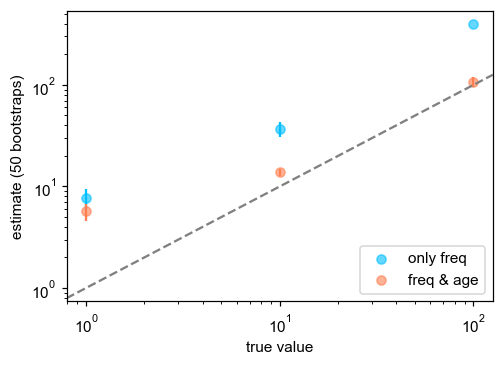

In [ ]:
## plotting truth vs mean + CI estimates 
plt.scatter([1.,10.,100.],[7.69,37.2,400],color='deepskyblue',alpha=0.6,label='only freq')
plt.scatter([1.,10.,100.],[5.69,13.8,107.5],color='coral',alpha=0.6,label='freq & age'); plt.legend(loc='lower right')
plt.errorbar([1.,10.,100.],[7.69,37.2,400],yerr=[1.7,6.2,0],color='deepskyblue',ls='none'); plt.xlabel('true value')
plt.errorbar([1.,10.,100.],[5.69,13.8,107.5],yerr=[1.1,1.1,12.8],color='coral',ls='none'); plt.ylabel('estimate (50 bootstraps)')
plt.loglog(); plt.axline((1,1),(100,100),color='grey',linestyle='--')

### Following manual from moments with Mende from Sierra Leone (MSL, 1000G) data 
#### (checking to see if we get similar DFE)

In [3]:
import pickle 
data = pickle.load(open("../testdata/sampleData/msl_data.bp", "rb"))

fs_syn = data["spectra"]["syn"]
fs_mis = data["spectra"]["mis"]
fs_lof = data["spectra"]["lof"]

u_syn = data["rates"]["syn"]
u_mis = data["rates"]["mis"]
u_lof = data["rates"]["lof"]

print("Diversity:")
print(f"synonymous:\t{fs_syn.pi():.2f}")
print(f"missense:\t{fs_mis.pi():.2f}")
print(f"loss of func:\t{fs_lof.pi():.2f}")

print()
print("Diversity scaled by total mutation rate:")
print(f"synonymous:\t{fs_syn.pi() / u_syn:.2f}")
print(f"missense:\t{fs_mis.pi() / u_mis:.2f}")
print(f"loss of func:\t{fs_lof.pi() / u_lof:.2f}")

Exception ignored in: <_io.FileIO name='../testdata/sampleData/msl_data.bp' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_79019/422844747.py", line 2, in <module>


Diversity:
synonymous:	8452.01
missense:	6991.16
loss of func:	95.16

Diversity scaled by total mutation rate:
synonymous:	58614.15
missense:	20408.81
loss of func:	3718.19


In [4]:
def model_func(params, ns):
    nuA, nuF, TA, TF, p_misid = params
    fs = moments.Demographics1D.snm(ns)
    fs.integrate([nuA], TA)
    nu_func = lambda t: [nuA * np.exp(np.log(nuF / nuA) * t / TF)]
    fs.integrate(nu_func, TF)
    return (1-p_misid) * fs + p_misid * fs[::-1]

p_guess = [2.0, 10.0, 0.3, 0.01, .02]
lower_bound = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
upper_bound = [10, 100, 1, 1, 1-1e-3]

opt_params = moments.Inference.optimize_log_fmin(
    p_guess, fs_syn, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound)

model = model_func(opt_params, fs_syn.sample_sizes)
opt_theta = moments.Inference.optimal_sfs_scaling(model, fs_syn)
Ne = opt_theta / u_syn / 4

print("optimal demog. parameters:", opt_params)
print("inferred Ne:", f"{Ne:.2f}")

optimal demog. parameters: [2.215 5.298 0.555 0.041 0.020]
inferred Ne: 11372.91


In [250]:
# np.arange(opt_params[2],opt_params[3]+opt_params[2],0.5/Ne)
opt_params[2]+opt_params[3]

0.5953820251775782

In [350]:
## code to construct demography for a constant + continuous expansion/decline phase
## add an extra burn-in period of 3(?) coalescent time units up front to achieve equilibrium
# burnin = 3
# Nc_mis = []
# Nc_mis.append(np.repeat(opt_params[0]*2*Ne,int((burnin+opt_params[2])*2*Ne)))
# Nc_mis = Nc_mis[0].tolist()
# [Nc_mis.append((opt_params[0]*np.exp(np.log(opt_params[1]/opt_params[0])*(t-(opt_params[2]+burnin))/opt_params[3]))*2*Ne) for t in np.arange(burnin+opt_params[2],burnin+opt_params[3]+opt_params[2],0.5/Ne)]
# Nc_mis = np.array(Nc_mis)
# nu_func_mis = lambda t: [Nc_mis[int(t*2*Ne)]/Ne] # Nc[0] = Ne
# plt.plot(Nc_mis[::-1]/1e5); plt.semilogx(); plt.xlabel('time in gens'); plt.ylabel('pop size in 10k inds')
Nc_mis
# Nc = np.array(list(it.chain(*Nc)))

array([50389.182, 50389.182, 50389.182, ..., 120176.827, 120289.561,
       120402.402])

In [5]:
## creating a demographic function that contains the same pop sizes as above
# len(data['spectra']['mis'])
dat = np.zeros((int(np.sum(fs_mis[1:-1])),6),dtype='int')
ctr = 0
for ix in range(1,len(fs_mis)-1):
    dat[ctr:(ctr+int(fs_mis[ix])),5] = ix
    dat[ctr:(ctr+int(fs_mis[ix])),3] = np.exp(rng.normal(1.163*np.log(ix)+4.9,0.25,int(fs_mis[ix])))
    ctr += int(fs_mis[ix])

dat[dat[:,3]>80000,3] = 80000

[]

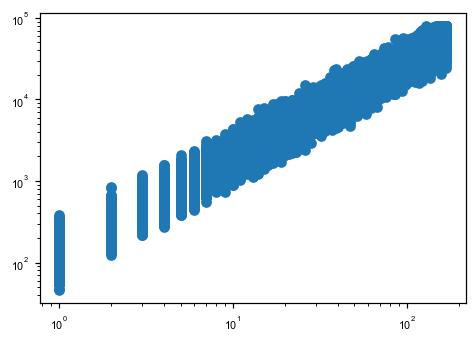

In [154]:
# rng.random.normal(1.163*np.log(25)+4.9,2,10)
# ctr:(ctr+int(fs_mis[ix])

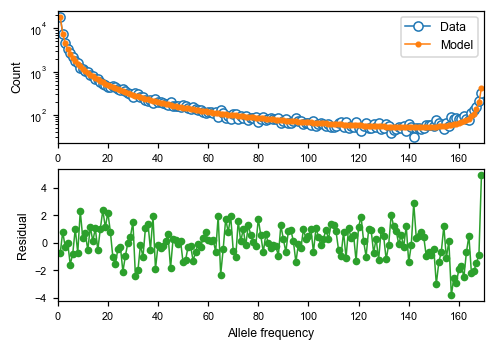

In [6]:
moments.Plotting.plot_1d_comp_multinom(model, fs_syn, residual="linear")

def selection_spectrum(gamma, h=0.5):
    rerun = True
    ns_sim = 100
    while rerun:
        ns_sim = 2 * ns_sim
        fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
        fs = moments.Spectrum(fs)
        fs.integrate([opt_params[0]], opt_params[2], gamma=gamma, h=h)
        nu_func = lambda t: [opt_params[0] * np.exp(
            np.log(opt_params[1] / opt_params[0]) * t / opt_params[3])]
        fs.integrate(nu_func, opt_params[3], gamma=gamma, h=h)
        if abs(np.max(fs)) > 10 or np.any(np.isnan(fs)):
            # large gamma-values can require large sample sizes for stability
            rerun = True
        else:
            rerun = False
    fs = fs.project(fs_syn.sample_sizes)
    fs[fs<0] = -fs[fs<0]
    return fs

spectrum_cache = {}
spectrum_cache[0] = selection_spectrum(0)

gammas = np.logspace(-3, 3, 30)
for gamma in gammas:
    spectrum_cache[gamma] = selection_spectrum(-gamma)

In [7]:
theta_mis = opt_theta * u_mis / u_syn

dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2
    + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=1):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return (1 - 0.0137) * fs + 0.0137 * fs[::-1]

def model_func_missense(params, ns):
    return dfe_func(params, ns, theta=theta_mis)

p_guess = [0.5, 10000]
lower_bound = [1e-4, 1e-1]
upper_bound = [1e1, 1e5]

opt_params_mis = moments.Inference.optimize_log_fmin(
    p_guess, fs_mis, model_func_missense,
    lower_bound=lower_bound, upper_bound=upper_bound,
    multinom=False)

model_mis = model_func_missense(opt_params_mis, fs_mis.sample_sizes)
print("optimal parameters:")
print("shape:", f"{opt_params_mis[0]:.4f}")
print("scale:", f"{opt_params_mis[1]:.1f}")
print("Log-likelihood:", moments.Inference.ll_multinom(model_mis, fs_mis))

optimal parameters:
shape: 0.1591
scale: 2466.4
Log-likelihood: -695.1244578923452


In [874]:
# np.sum(-model_mis.data + fs_mis.data*model.log() - sp.special.gammaln(fs_mis + 1.)), moments.Inference.ll_multinom(model_mis, fs_mis), moments.Inference.ll_multinom(dfe_func([alpha[10],beta[34]],170,theta_mis), fs_mis)
moments.Plotting.plot_1d_comp_Poisson(model_mis, fs_mis)

NameError: name 'model_mis' is not defined

### Trying to recapture the same estimates as above using our procedure and their data

#### Lessons learned:

1. **DO NOT NORMALIZE SFS**
2. Get an estimate of $\Theta$ by some PReFerSim magic (divide the total # of fixed/lost sites by the exp in $\gamma=0\ldots$?)
3. Leave $\gamma$ as positive in the cache, goes from -0.001 to 1000 on logscale
4. Take log10 for the estimates

In [9]:
sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,100]),method='L-BFGS-B',args=({'p_xa_s':spectrum_cache,'gamma':gammas,'sfs':fs_mis,'p_misid':0.0137,'theta':18000}),bounds=((-2,0),(0,4)))

      fun: 693.7730118228467
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.015, 0.006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 13
     njev: 23
   status: 0
  success: True
        x: array([-0.801, 3.806])

In [447]:
del up_xa_s
up_xa_s = {}
up_xa_s[0] = run_mom_iterate_changing(170, 0, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
for ig, g in enumerate(gammas):
    up_xa_s[g] = run_mom_iterate_changing(170, -g*.5/Ne, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g][:,np.arange(1,170)] = up_xa_s[g][:,np.arange(1,170)]/np.sum(up_xa_s[g][:,np.arange(1,170)])

## rescaling to keep mass similar to the SFS for a given gamma 
# up_xa_s[0] = up_xa_s[0]*spectrum_cache[0].sum()/up_xa_s[0].sum()
# for g in gammas:
#     up_xa_s[g] = up_xa_s[g]*spectrum_cache[g].sum()/up_xa_s[g].sum()

In [460]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.8,200]),method='L-BFGS-B',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.0137,'theta':800}),bounds=((-2,0),(0,4)))

      fun: 113267.6931653765
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([25492.907, 0.000])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 174
      nit: 4
     njev: 58
   status: 2
  success: False
        x: array([-0.324, 2.503])

In [455]:
get_ll_freqagechanging(np.log10([0.5,500]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.0137,'theta':800}))

122298.60220070173

In [389]:
# plt.imshow(up_xa_s[gammas[-2]][-100:,],aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()

array([50389.182, 50389.182, 50389.182, 50389.182, 50389.182, 50389.182,
       50389.182, 50389.182, 50389.182, 50389.182, 50389.182, 50389.182,
       50389.182, 50389.182, 50389.182, 50389.182, 50389.182, 50389.182,
       50389.182, 50389.182])

### Changing demographic history (Tennessen et al 2012) with Boyko DFE parameters
DFE: $\text{Beta}(\alpha=0.2,\beta=200)$

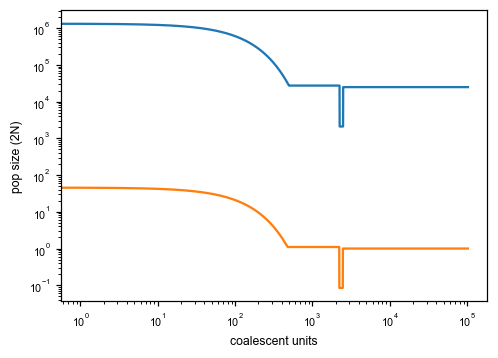

In [211]:
demo = np.loadtxt("simfiles/1kg_1.5_n10_prefersim_demo.txt", delimiter=" ", dtype='int')
Nc = []
[Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
nu_func = lambda t: [Nc[int(t*24757)]/Nc[0]] # Nc[0] = N = 12378
Nc = np.array(list(it.chain(*Nc)))
plt.plot(Nc[::-1]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
plt.plot([nu_func(t) for t in np.linspace(4.139,0,len(Nc))]); plt.loglog(); plt.xlabel('coalescent units'); 

## Simulating data under the moments model using a Poisson likelihood

Using $\theta=100$ and $\gamma=-20$ with $n=500$ 

In [35]:
fs = moments.LinearSystem_1D.steady_state_1D(200, gamma=-5, theta=100)
fs = moments.Spectrum(fs)
fs.integrate([1], 3, gamma=-5, theta=100)
fs = fs.project([200]) 
fs[fs<0] = -fs[fs<0]

fsa = run_mom_iterate_constant(10000, 200, -20/10000, 10000, 100, {})
fsa[fsa<0] = -fsa[fsa<0]

# for i in range(1,len(sfs)):
#     fsa[:,i] *= fs[i]/fsa.sum(axis=0)[i]

sfs = np.zeros(len(fs))
for i in range(1,len(fs)-1):
    sfs[i] = rng.poisson(fs[i],1)

mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        # if rng.binomial(1,0.25,1):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)

In [38]:
# fsa_est = get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},100)
# fsa_est.shape, fsa.shape, SMS.shape
# SMS[:5,:5], fsa[-5:,:5]
# SMS.nonzero()[0][-10:]
# np.allclose(fsa[:19955,:],fsa_est)
# SMS.sum()*2/sfs.sum()
# fsa.sum()*2/fs.sum()
sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':120,'N':10000,'p_misid':0,'gens':10000},200),tol=1e-2,bracket=(-2,3))
# plt.plot(fsa.sum(axis=1)); plt.loglog(); plt.axhline(1e-3)
# np.where(fsa.sum(axis=1)>
# get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':10000},200)

     fun: 33820.174146660334
    nfev: 14
     nit: 10
 success: True
       x: 1.3459852991626884

In [738]:
## finding gamma estimates using SFS from each generation

# llperage = [10**sp.optimize.minimize_scalar(get_ll_freqcondageconstant,args=({'sfs':SMS[i,],'theta':100,'N':10000,'p_misid':0,'age':i},250)).x for i in np.geomspace(1,15000,100,dtype=int)]
# plt.scatter(np.geomspace(1,15000,100),llperage,color='k'); plt.grid(); plt.loglog(); plt.axhline(20,color='red'); plt.xlabel('age'); 
# plt.ylim((1,500)); plt.ylabel(r'$\hat \gamma$') 
# sp.stats.mstats.hmean(llperage), np.mean(llperage)

# llperageafs = [10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS[:i,],'theta':166,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3)).x for i in np.linspace(2,4000,100,dtype=int)]
# sp.stats.mstats.gmean(llperageafs[1:1000]), np.mean(llperageafs[1:80])
# plt.scatter(np.linspace(2,4000,100)[1:],llperageafs[1:],color='k',alpha=0.6); plt.grid();  plt.axhline(20,color='red'); plt.xlabel('age'); plt.ylabel(r'$\hat \gamma$'); 

# llperagesfs = [10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':SMS[i,],'theta':100,'N':10000,'p_misid':0,},250)).x for i in np.geomspace(1,500,20,dtype=int)]
# plt.scatter(np.geomspace(1,500,20),llperagesfs,color='k'); plt.grid(); plt.loglog(); plt.axhline(20,color='red'); plt.xlabel('age'); plt.ylim((1,500)); plt.ylabel(r'$\hat \gamma$')

(1.7231907560759452e-14, 20.7034183697288)

In [740]:
# np.linspace(2,10000,50,dtype=int)
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS[:2,],'theta':166,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3)).x
np.linspace(1,4000,100)[80]
## relationship between estimated theta and gamma (across various simulated gamma values)
# thetas = np.linspace(50,1000,15)
# gamest = np.zeros((5,len(thetas)))
# for it, t in enumerate(thetas):
#     gamest[4,it] = 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250)).x

3232.515151515151

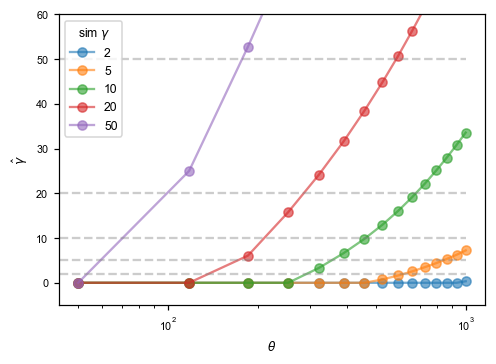

In [643]:
# gamest 
lo = plt.plot(thetas,gamest.T,'-o',alpha=0.6); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\hat \gamma$'); plt.semilogx(); plt.ylim((-5,60))
plt.legend(iter(lo),[2,5,10,20,50],title=r'sim $\gamma$'); plt.hlines([2,5,10,20,50],0,1000,color='grey',ls='--',alpha=0.4); 

(array([2.000, 3.000, 6.000, 13.000, 39.000, 95.000, 403.000, 6806.000,
        488.000, 99.000, 27.000, 8.000, 3.000, 5.000, 3.000]),
 array([-17.791, -15.440, -13.089, -10.738, -8.386, -6.035, -3.684, -1.333,
        1.019, 3.370, 5.721, 8.072, 10.423, 12.775, 15.126, 17.477],
       dtype=float32),
 <BarContainer object of 15 artists>)

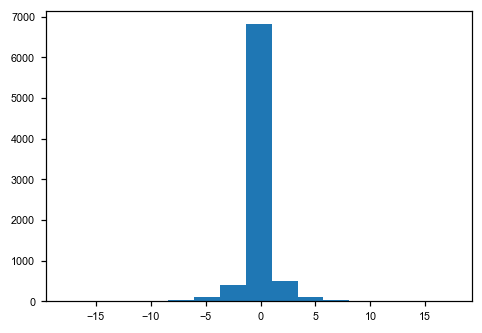

In [220]:
## compute average standardized residuals
# nsims = 5
# res_SMS = np.zeros_like(fsa)
# for i in range(1,SMS.shape[0]):
#     for j in range(1,SMS.shape[1]):
#         res_SMS[i,j] = ((np.repeat(fsa[-i,j],nsims) - rng.poisson(fsa[-i,j],nsims))/np.sqrt(np.repeat(fsa[-i,j],nsims))).mean()

# plt.imshow(res_SMS[:500,:100],cmap='RdBu',aspect='auto',norm=colors.TwoSlopeNorm(vcenter=0,vmin=-10,vmax=10)); plt.colorbar(); plt.xlabel('Allele frequency'); plt.ylabel('gens')
# plt.imshow(fsa[-400:,:20][::-1]-SMS[1:401,:20],cmap='RdBu',aspect='auto',norm=colors.TwoSlopeNorm(vcenter=0,vmax=10,vmin=-10)); plt.colorbar(); plt.xlabel('Allele frequency'); plt.ylabel('gens')
plt.hist(np.ravel(fsa[-400:,:20][::-1]-SMS[1:401,:20]),15)
# res_SMS.argmin()
# np.argwhere(res_SMS == np.nanmin(res_SMS))
# ((np.repeat(fsa[-8937,285],5) - rng.poisson(fsa[-8937,285],5))/np.sqrt(np.repeat(fsa[-8937,285],5)))
# SMS[8937,285], (SMS[8937,285]-fsa[-8937,285])/np.sqrt(fsa[-8937,285])

In [1540]:
## computing residuals from the data SMS and the model
thetas = np.linspace(100,1500,25)
resid = np.zeros(len(thetas))
nzidx = SMS.nonzero()
for it, t in enumerate(thetas):
    resid[it] = (-fs*1000/t + np.log(fs*1000/t) * sfs - sp.special.gammaln(sfs+1)).sum()
    # for i in range(len(nzidx[0])):
    #     resid[it] += -fsa[-nzidx[0][i],nzidx[1][i]]*1000/t + np.log(fsa[-nzidx[0][i],nzidx[1][i]]*1000/t)*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)

(array([0.000, 1007.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000], dtype=float32),
 array([0.000, 999.105, 0.175, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000], dtype=float32))

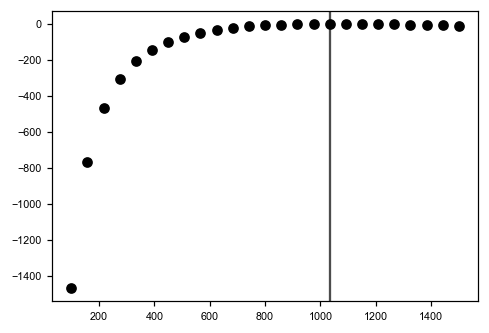

In [1541]:
plt.plot(thetas,resid-resid.max(),'ko'); plt.axvline(thetas[resid.argmax()],color='k',alpha=0.7); 
# thetas
# nzidx
SMS[1,:20], fsa[-1,:20]

In [1239]:
# plt.hist(rng.poisson(fsa[-1,2],50))
SMS[50,:10], fsa[-50,:10]
# nzidx[0][:2], nzidx[1][:2]

(array([0.000, 363.000, 134.000, 68.000, 24.000, 9.000, 3.000, 1.000,
        2.000, 1.000], dtype=float32),
 array([0.000, 378.569, 145.509, 55.862, 21.421, 8.205, 3.140, 1.200,
        0.458, 0.175], dtype=float32))

[]

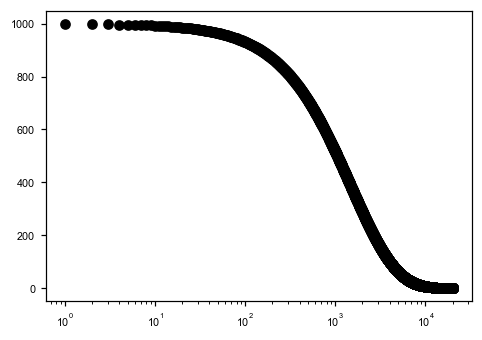

In [1542]:
# plt.scatter(fs,fsa.sum(axis=0)); plt.axline((0,0),slope=160); 
# res = 0
# nzidx = SMS.nonzero()
# for i in range(10):
#     res += -fsa[-nzidx[0][i],nzidx[1][i]] + np.log(fsa[-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
#     print(SMS[nzidx[0][i],nzidx[1][i]],fsa[-nzidx[0][i],nzidx[1][i]],sp.stats.poisson.logpmf(SMS[nzidx[0][i],nzidx[1][i]],fsa[-nzidx[0][i],nzidx[1][i]]))
# print(res)

# fs[10], fsa.sum(axis=0)[10]
# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-5)); plt.colorbar()
# plt.plot(fsa.sum(axis=1)[::-1],'ko',); plt.semilogx()

In [18]:
# SMS[nzidx[0][10], nzidx[1][10]], fsa[-nzidx[0][10], nzidx[1][10]]
# fsa.sum()/SMS.sum()
# sp.stats.poisson.logpmf(SMS[1,1], fsa[-1,1])
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},100),tol=1e-2,bracket=(-2,3))

array([[0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 990.000, 1.000, ..., 0.000, 0.000, 0.000],
       [0.000, 1034.000, 3.000, ..., 0.000, 0.000, 0.000],
       ...,
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000]], dtype=float32)

In [703]:
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':800,'p_misid':0},500),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':1000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+1},max(SMS.nonzero()[1])+1),tol=1e-1,bracket=(-2,3))

thetas = np.linspace(50,200,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3))
    ltfa.append(res.fun)
    ## ltfa.append(get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250))
    gtfa.append(10**res.x)

In [705]:
# plt.plot([4,10,20,40,100],[1300,850,470,290,180],'ko',); plt.semilogx(); plt.xlabel(r'$\hat \gamma$'); plt.ylabel(r'$\theta$'); plt.grid(); plt.axhline(100,color='grey',ls='--')
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':100,'N':10000,'p_misid':0},250),tol=1e-2,bracket=(-2,3))
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':10000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3)).x 
# np.polyfit(thetas,-np.array(ltfa),2)
thetas[np.argmin(ltfa)]

166.66666666666669

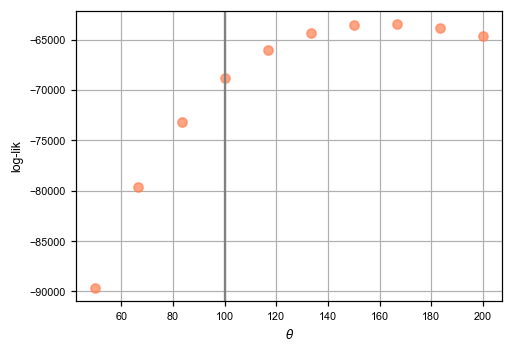

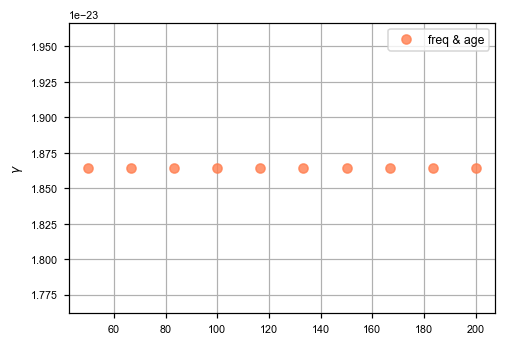

In [704]:
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':330,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':120,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
# plt.scatter(thetas[:4],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.axvline(100,color='grey'); plt.grid(); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.show()
plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(100,color='grey'); plt.grid(); plt.show()
# plt.scatter(thetas[:4],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(20,color='red'); plt.xlabel(r'$\theta$'); 
plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.grid(); plt.show()

Text(0, 0.5, 'gens')

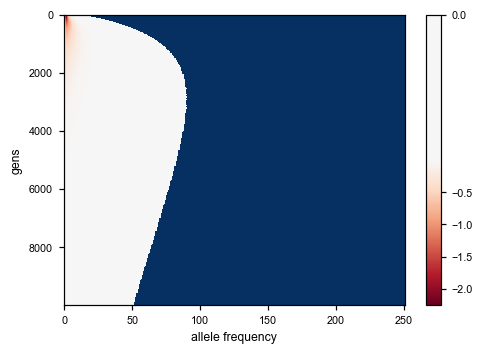

In [121]:
## plot residuals of true and estimated gamma & theta
fst = run_mom_iterate_constant(10000, 250, -100/10000, 10000, 1, {})
# plt.imshow(((fst-fsa)/np.sqrt(fst))[::-1],aspect='auto',cmap='RdBu',norm=colors.TwoSlopeNorm(vcenter=0)); plt.colorbar(); plt.xlabel('allele frequency'); plt.ylabel('gens')
np.sqrt(np.nanmean((np.log(fst+1)-np.log(fsa+1))**2))

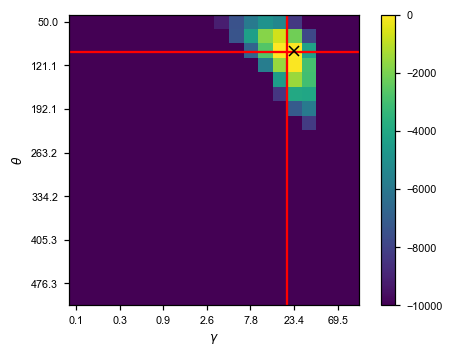

In [76]:
## log-lik 2D surface over theta and gamma
# thetas = np.linspace(50,500,20)
# gammas = np.logspace(-1,2,20,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':10000},200)

plt.imshow(-ll2d+np.min(ll2d),vmin=-10000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,20,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,20,3),labels=np.round(gammas[::3],1)); 
plt.axvline(14.5,color='red'); plt.axhline(2.1,color='red'); plt.plot(15,2,'kx')
# np.argwhere(ll2d==np.min(ll2d))

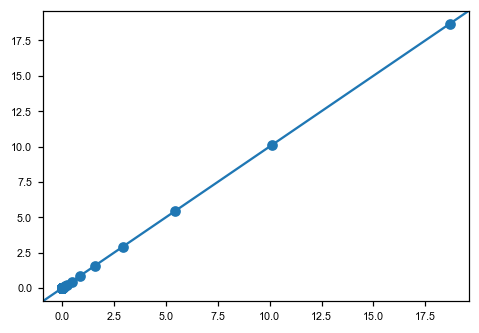

In [83]:
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':1000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},1000),tol=1e-2,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqcondageconstant,args=({'sfs':sfs,'theta':1000,'N':10000,'p_misid':0,'age':10000},500),tol=1e-2,bracket=(-2,3))

# run_mom_iterate_constant(10, 500, -0.5*20/10000, 10000, 1000,{})[-10,:], sfs

fst = moments.Spectrum(np.zeros(251))
fst[1] = 100
fst.integrate([1], 200/20000, gamma=-13, theta=0)

# plt.scatter(fs,fst); plt.axline((0,0),slope=1); plt.loglog()
# np.allclose(fs,fst)

fsa = run_mom_iterate_constant(2000, 250, -13/10000, 10000, 100, {})

# # moments.Plotting.plot_1d_fs(fs)
plt.scatter(fst,fsa[-200,:]); plt.axline((0,0),slope=1); #plt.loglog()
# np.corrcoef(fst[1:], fsa[-100,1:])
# thetas[4]

In [664]:
fst[1:10], fsa[-200,1:10]

(Spectrum([18.93336205799307 10.302703110259207 5.597568104280357 3.0365138534551437
  1.6446819032053575 0.889451982291373 0.4802864174637022
  0.2589516207447414 0.13940581319115108], folded=False, pop_ids=None),
 array([18.936, 10.302, 5.597, 3.036, 1.645, 0.889, 0.480, 0.259, 0.139],
       dtype=float32))

In [627]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/ConstantSize29.76.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*2000)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 80000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

In [1222]:
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':9000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},500),tol=1e-1,bracket=(-2,3)).x
# 10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':1000,'p_misid':0},500),tol=1e-1,bracket=(-2,3),options={'maxiter':20}).x

1.9595238658677034

In [857]:
# plt.scatter(df1['sXl'],df1['al']); plt.loglog()
# np.polyfit(np.log(df1['sXl']),np.log(df1['al']),deg=1)
# alpha = np.array([0.1,0.25,0.5]); beta = np.array([100,250,500]); collist = ['grey','goldenrod','salmon']
# for i in [10,20,30]:
#     df1 = pd.read_csv("outfiles/gammaHuber17Unif.{}.full_out.txt".format(i),sep='\t',header=None,names=['','Xl','s','al','id'])
#     df1['al'] = 80000+1-df1['al']
#     plt.hist(df1['al'],color=collist[i//10-1],label=r'mean $\gamma = -{}$'.format(alpha[i//10-1]*beta[i//10-1]),alpha=0.5); plt.legend(); plt.title(r'allele ages with Gamma($\alpha, \beta$)')

array([1.072, 5.232])

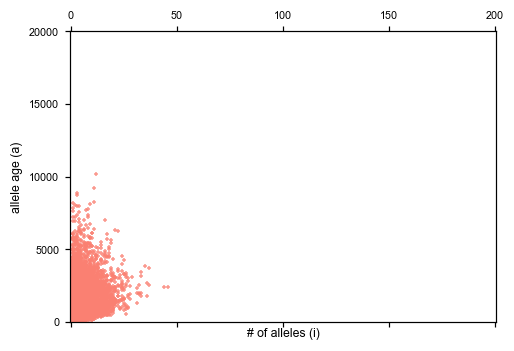

In [11]:
## create a SMS (matrix) instead of SFS
# SMS = np.zeros((80000,2000+1),dtype='int16')
# for i in range(len(dat)):
#     SMS[dat[i,3],dat[i,5]] += 1
# SMS = sp.sparse.csc_matrix(SMS)
plt.spy(SMS,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()
# plt.plot(nzidx[1],nzidx[0],'ko'); plt.loglog()
# plt.plot(np.ravel(SMS.sum(axis=1)),'ko',); plt.semilogy()

# prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
# dadisfs = np.zeros((2000+1,)).astype('int')
# for n in range(0, len(prfsim.columns)-1):
#     dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

# f = open("outfiles/ConstantSize6.95.2.dadi.sfs_out.txt", "w")
# f.write("201 unfolded\n")
# f.write(' '.join(map(str, dadisfs)))
# f.close()

# sfs = moments.Spectrum.from_file("outfiles/ConstantSize6.95.2.dadi.sfs_out.txt")
# sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,2002))[0])
# moments.Plotting.plot_1d_fs(sfs)

# plt.scatter(np.arange(1,172),fs_mis,color='goldenrod',alpha=0.6,label='moments'); plt.scatter(np.arange(1,172),43*sfs[:171],color='purple',alpha=0.4,label='scaled PReFerSim'); 
# plt.xlabel('Allele frequency'); plt.title('SFS with Gamma(0.18,2000) DFE'); plt.legend(); plt.semilogy(); plt.grid()

1e-08

In [651]:
# np.histogram(df1['gamma'],bins=[0,0.5,5,50,200])[0]/len(df1)
# plt.scatter(np.sort(df1['s']),np.sort(sp.stats.gamma.rvs(0.2,scale=400,size=len(df1))/2000))
# sm.qqplot(df1['s']*20000,sp.stats.distributions.gamma(0.2,scale=400),label=r'simulated (shape=0.2,scale=400)',line='45'); 
# sm.qqplot(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=2000$')
# sm.qqplot(sp.stats.gamma.rvs(0.216,scale=5363,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=1700$')
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.091
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.216,scale=1286,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.047

0.17421

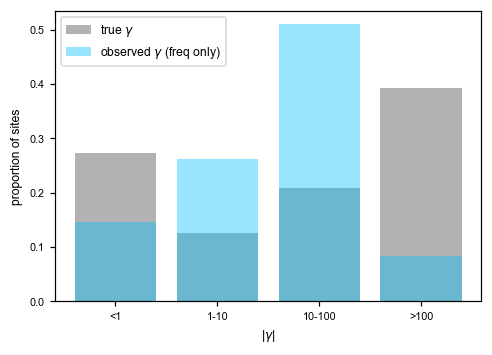

In [139]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
# df1['gamma'] = df1['s']*20000
# plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'observed $\gamma$')
# df1['gamma_inf'] = sp.stats.gamma.rvs(0.174,scale=200,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],color='steelblue',alpha=0.6,label=r'simulated $\gamma$'); plt.legend()
# plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')

df1['gamma'] = sp.stats.gamma.rvs(0.18,scale=2000,size=len(df1)) #df1['s']*20000
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'true $\gamma$')
# df1['gamma_inf'] = sp.stats.gamma.rvs(0.174,scale=1800,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],color='steelblue',alpha=0.4,label=r'observed $\gamma$ (moments)');
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')
df1['gamma_inf2'] = sp.stats.gamma.rvs(0.492,scale=70,size=len(df1))
plt.bar(np.arange(4),[np.sum(df1['gamma_inf2']<1)/len(df1),np.sum((df1['gamma_inf2']>1) & (df1['gamma_inf2']<10))/len(df1),np.sum((df1['gamma_inf2']>10) & (df1['gamma_inf2']<100))/len(df1),np.sum(df1['gamma_inf2']>100)/len(df1)],color='deepskyblue',alpha=0.4,label=r'observed $\gamma$ (freq only)');
# df1['gamma_inf3'] = sp.stats.gamma.rvs(0.413,scale=2000,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf3']<1)/len(df1),np.sum((df1['gamma_inf3']>1) & (df1['gamma_inf3']<10))/len(df1),np.sum((df1['gamma_inf3']>10) & (df1['gamma_inf3']<100))/len(df1),np.sum(df1['gamma_inf3']>100)/len(df1)],color='salmon',alpha=0.4,label=r'observed $\gamma$ (freq & age)'); 
plt.legend()

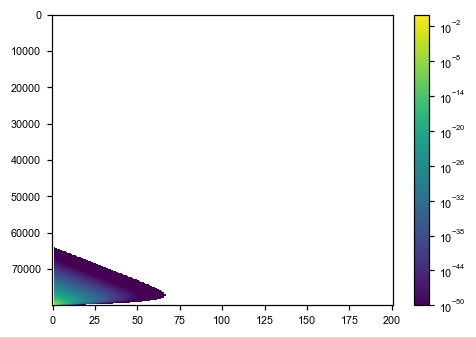

In [525]:
# my_cmap = copy(cm.get_cmap('viridis'))
# my_cmap.set_bad(my_cmap.colors[0])
# Nc = np.linspace(10000,12000,250,dtype='int')
# temp = run_mom_iterate_changing(1000, gamma[-1], Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# temp = run_mom_iterate_constant(len(Nc), 1000, gamma[-1]*0.5/Nc[0], 15000, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
plt.imshow(up_xa_s[gammas[-10]],aspect='auto',interpolation='nearest',norm=colors.LogNorm(vmin=1e-50),); plt.colorbar()

In [4]:
# gamma = -np.geomspace(1e-7,5e-3,20)
# gamma = -np.linspace(0.01,500,25)/40000 ## for constant pop size (spans a greater range...)
gamma = (-10**np.linspace(-0.5,2.5,25))/40000 

[]

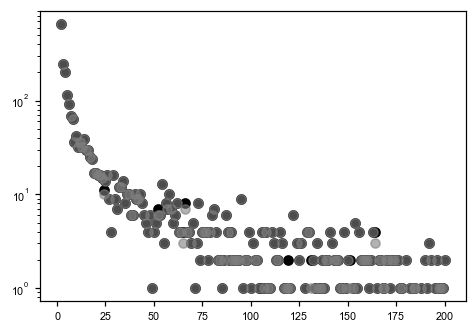

In [800]:
plt.scatter(range(1,202),sfs,color='k'); plt.scatter(range(1,202), np.ravel(SMS[1:].sum(axis=0)),color='grey',alpha=0.6); plt.semilogy()
# np.argsort(abs(sfs-np.ravel(SMS[1:].sum(axis=0))))
# sfs[29], np.ravel(SMS[1:].sum(axis=0))[29]
# np.where(dat[:,5]==29)
# sfs[29]

In [370]:
## creating a database of P(X, a | s) with dicts for different s values
# n = 200
# cutoff = 1
# del up_xa_s
# gammas = np.logspace(-3,3,30)
# up_xa_s = {}
# up_xa_s[0.0] = run_mom_iterate_constant(80000, 2000, 0, 10000, 1, {})
# for ig, g in enumerate(gammas):
# #     up_xa_s[g] = run_mom_iterate_changing(1000, -0.5*g/10000, Nc[::-1][:92516], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
#     up_xa_s[g] = run_mom_iterate_constant(80000, 2000, -0.5*g/10000, 10000, 1, {})

# for g in np.append(gammas,0):
#     up_xa_s[g] = up_xa_s[g]/up_xa_s[g].sum()

# del p_xa_s
p_xa_s = {}
for g in np.append(gammas,0):
    # up_xa_s[g] = up_xa_s[g]*p_xa_s[g].sum()/up_xa_s[g].sum()
    fs = moments.LinearSystem_1D.steady_state_1D(10000, gamma=-g)
    fs = moments.Spectrum(fs)
    fs.integrate([0.5], 6, gamma=-g) ## for constant stuff 
    fs = fs.project([2000]) 
    fs[fs<0] = -fs[fs<0]
    p_xa_s[g] = fs

In [99]:
# theta = np.geomspace(1,50000,20)
# lltheta_age = []
# lltheta_freq = []
# for t in theta:
#     lltheta_freq.append(-get_ll_freqchanging(np.log10([0.2,2000]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':t})))
#     lltheta_age.append(-get_ll_freqagechanging(np.log10([0.2,2000]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':t})))

# plt.scatter(theta, lltheta_freq, color='deepskyblue', alpha=0.6, label='freq only'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); 
# plt.title(r'holding $(\alpha,\beta)$ at MLE'); plt.yscale('symlog'); plt.semilogx(); plt.grid(); plt.axvline(2000,color='k',ls='--',alpha=0.6,label='simulated')
# plt.scatter(theta, lltheta_age, color='coral', alpha=0.6, label='freq & age'); plt.legend(); 

# weights = sp.stats.gamma.pdf(gammas, 0.2, scale=5000)
# fsa = up_xa_s[0] * sp.stats.gamma.cdf(gammas[0],0.2,scale=5000)
# for g, dx, w in zip(gammas, dxs, weights):
#     fsa += up_xa_s[g] * dx * w
# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()
# fsa = fsa * SMS.sum()/fsa.sum()
# res = 0
# nzidx = SMS.nonzero()
# for i in range(1797):
#     # print(fsa[-nzidx[0][i],nzidx[1][i]],SMS[nzidx[0][i],nzidx[1][i]])
#     res += -fsa[-nzidx[0][i],nzidx[1][i]] + np.log(fsa[-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
# print(res)
# get_ll_freqagechanging(np.log10([0.12,275]),({'up_xa_s':up_xa_s,'gamma':np.logspace(-3,3,40),'sms':SMS,'p_misid':0.00,'theta':20}))

KeyboardInterrupt: 

In [262]:
## with fs_mis data 
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.9,1000]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':moments.Spectrum(data),'p_misid':0.00,'theta':10}),bounds=((-2,0),(0,4.5)))
## with constant demo and (0.18, 2000) w PReFerSim
# for t in np.linspace(1000,3000,10):
#     res = sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,2000]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':t}),bounds=((-2,0),(0,4.5))); print(10**res.x, res.fun, t)
# res = sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,2000]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':2000}),bounds=((-2,0),(0,4.5))); print(10**res.x, res.fun)
# res = sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.5,1000]),method='L-BFGS-B',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':10}),bounds=((-2,0),(0,4.5))); print(10**res.x, res.fun)
# for g in np.append(gammas,0):
#     print(up_xa_s[g].sum()/p_xa_s[g].sum())

[0.243 31622.777] 1662.671854796052


In [408]:
## works well, though freq is ~10x faster (~20% relative error for both)
# sp.optimize.minimize_scalar(get_ll_freqchanging, args=({'nu': nu_func,'T':4.139,'Nc0':Nc[0],'dt_fac':0.0005,'theta':1}, dat[:,5]), options={'xtol':1e-6}, bracket=(-5e-2,-1e-5))
# sp.optimize.minimize_scalar(get_ll_freqagechanging, args=({'Nc':Nc[::-1][:92516]}, dat[:,5], dat[:,3]), options={'maxiter':25,'xtol':1e-6}, bracket=(-4e-3,-1e-5))
## set up a framework for estimation of gamma for point DFE
## (all this requires is calculating the res for each value of g)
theta = np.geomspace(100,5000,15)
res_t = np.zeros((len(theta),2))
ll_t = np.zeros((len(theta),2))
nzidx = SMS.nonzero()
for it, t in enumerate(theta):
    res_f = np.zeros(len(gammas))
    res_a = np.zeros(len(gammas))
    for ig, g in enumerate(gammas):
        for i in range(1,len(sfs)-1):
            res_f[ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
        for i in range(len(nzidx[0])):
            res_a[ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
    ll_t[it,0] = np.nanmax(res_f)
    ll_t[it,1] = np.nanmax(res_a)
    res_t[it,0] = gammas[np.nanargmax(res_f)]
    res_t[it,1] = gammas[np.nanargmax(res_a)]

# theta = np.geomspace(100,1e6,15)
# ll_tf = np.zeros((len(theta),len(gammas)))
# ll_ta = np.zeros((len(theta),len(gammas)))
# nzidx = SMS.nonzero()
# for it, t in enumerate(theta):
#     for ig, g in enumerate(gammas):
#         ll_tf[it,ig] = (-t*p_xa_s[g][:-2] + np.log(t*p_xa_s[g][:-2]) * sfs - sp.special.gammaln(sfs+1)).sum()
#         # for i in range(1,len(sfs)-1):
#         #     ll_tf[it,ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
#         for i in range(len(nzidx[0])):
#             ll_ta[it,ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)

In [617]:
# (-p_xa_s[g][:-2] + np.log(p_xa_s[g][:-2]) * sfs - sp.special.gammaln(sfs+1)).sum()
# for i in range(1,len(sfs)-1):
#     ll_tf[it,ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)

theta = np.linspace(5000,25000,5)
# ll_t = np.zeros((len(theta),2))
# res_t = np.zeros((len(theta),2))
for it, t in enumerate(theta):
    # res_f = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0}),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ll_t[it,0] = res_f.fun
    # res_t[it,0] = 10**res_f.x

    res_a = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))
    ll_t[it,1] = res_a.fun
    res_t[it,1] = 10**res_a.x

# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':2000,'p_misid':0}),tol=1e-1,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':5000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(1e-20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100})

In [634]:
# ll_t, res_t, theta
print(sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':1700,'p_misid':0}),tol=1e-1,bracket=(-2,3)))
sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':2000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))

     fun: 461.8218604809389
    nfev: 11
     nit: 7
 success: True
       x: 1.351534947193181


     fun: 63540.41571080655
    nfev: 11
     nit: 7
 success: True
       x: 1.8196600480436835

In [606]:
# np.arange(0,len(gammas),3), gammas[::3]
# resxx = 0
# for i in range(2070):
#     resxx += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
# print(resxx)
# nzidx[0][2080], nzidx[1][2080]
sfs.sum()*2/p_xa_s[0].sum()

3359.042026234693

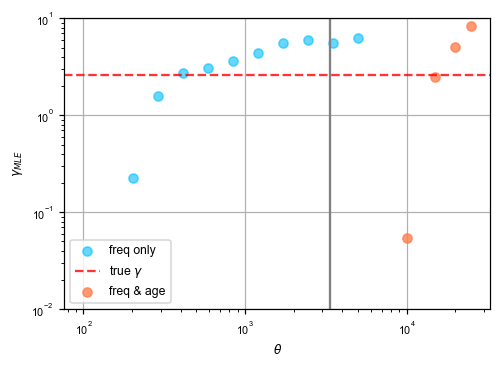

In [626]:
plt.scatter(np.geomspace(100,5000,12),res_t[:,0],alpha=0.6,color='deepskyblue',label='freq only'); plt.axhline(2.64,color='red',ls='--',alpha=0.8,label=r'true $\gamma$'); 
# plt.scatter(theta[ll_t.argmax(axis=0)[0]],res_t[ll_t.argmax(axis=0)[0],0],color='deepskyblue',marker='*',s=200); 
plt.ylim(1e-2,1e1); #plt.xlim(500,1e4)
# plt.scatter(theta[ll_t.argmax(axis=0)[1]],res_t[ll_t.argmax(axis=0)[1],1],color='coral',marker='*',s=200); 
plt.axvline(sfs.sum()*2/p_xa_s[0].sum(),color='grey')
plt.scatter(theta,res_t[:5,1],alpha=0.8,color='coral',label='freq & age'); plt.grid(); plt.loglog(); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\gamma_{MLE}$'); plt.legend(); 

# plt.imshow(ll_tf-np.nanmax(ll_tf),cmap='cividis',vmin=-100); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));
# plt.show()
# plt.imshow(ll_ta-np.nanmax(ll_ta),cmap='cividis',vmin=-200); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));

In [201]:
## inference procedure for gamma, but only point DFE (does this work first? Yes, it does!)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = len(Nc) + 1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*20000

    dub_onlyfreq, dub_onlyage = np.zeros((len(gamma))), np.zeros((len(gamma))) 
    for ig, g in enumerate(gamma):
        dub_onlyfreq[ig] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
        dub_onlyage[ig] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))

    mlefreq.append(np.argmax(dub_onlyfreq))
    mleage.append(np.argmax(dub_onlyage))

In [202]:
gamma[mlefreq]*1e5, gamma[mleage]*1e5, -0.00025*1e5
# np.sum(get_lp_alxl(up_xa_s, gamma[-0], dat[:,5], dat[:,3], cutoff=2))

(array([-26.334, -26.334, -26.334]), array([-26.334, -26.334, -18.987]), -25.0)

In [14]:
# plt how wt changes with a and b — prior distribution for a specific gamma
priorwt = np.zeros((25,25))
for ia, a in enumerate(alpha):
    for ib, b in enumerate(beta):
        priorwt[ia,ib] = sp.stats.gamma.logpdf(-24757*gamma[-12],a,scale=b)
plt.imshow(priorwt-np.max(priorwt)); plt.colorbar()

NameError: name 'alpha' is not defined

In [356]:
## code to convert PReFerSim sfs_out file to dadi sfs in file
prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
dadisfs = np.zeros((200+1,)).astype('int')
for n in range(0, len(prfsim.columns)-1):
    dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

f = open("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt", "w")
f.write("201 unfolded\n")
f.write(' '.join(map(str, dadisfs)))
f.close()

In [61]:
## fitdadi framework for DFE inference
# sel_params = [0.5, 1000.]
# lower_bound, upper_bound = [1e-3, 1.], [1, 5000.]
# p0 = dadi.Misc.perturb_params(sel_params,lower_bound=lower_bound,upper_bound=upper_bound)
# def DemoTenn12(params, ns, pts):
#     N1,T1,N2,T2,NC,TC, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 0.01, N1, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, T2, N2, gamma=gamma)
#     nu_func = lambda t: N2*np.exp(np.log(NC/N2)*t/TC)
#     phi = dadi.Integration.one_pop(phi, xx, TC, nu_func, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs
# def DemoConstant(params, ns, pts):
#     N1, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 6, N1, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs

# spectra = dadi.DFE.Cache1D([0.5], [1000], DemoConstant, pts_l=[1500], gamma_bounds=(1e-3, 500), gamma_pts=20, verbose=True, mp=False)

# popt, llopt = dadi.Inference.opt(p0, data, spectra.integrate, pts=None, func_args=[DFE.PDFs.gamma, 100], lower_bound=lower_bound, upper_bound=upper_bound, verbose=len(sel_params), maxtime=10, multinom=True)
# print(popt, llopt)

# model_sfs = spectra.integrate(popt, None, DFE.PDFs.gamma, 100, None)
# moments.Plotting.plot_1d_fs(model_sfs)

In [2]:
## code for finding the approx demo that matches the simulated distribution 
## DOESN'T WORK BECAUSE I DO NOT HAVE SYNONYMOUS SITES IN MY SIMULATED DATA (CANNOT USE SELECTED SITES)
# def DemoConstantMom(params, ns):
#     N1, T1 = params
#     fs = moments.Demographics1D.snm(ns)
#     fs.integrate([N1], T1)
#     return fs

# opt_params = moments.Inference.optimize_log_fmin([0.8,5], moments.Spectrum(data), DemoConstantMom, lower_bound=[0.1,0.1], upper_bound=[5,10])
# print(opt_params)

NameError: name 'np' is not defined

In [842]:
## moments framework for DFE inference
## A couple of outstanding questions:
# 1. what does dxs do? 
# 2. is theta a big deal here?
# 3. increase the number AND range of gamma values
# 4. include pmis...
# WHY IS moments NOT WORKING EITHER??? is the biggest question
data = moments.Spectrum.from_file("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt")
def selection_spectrum(gamma, h=0.5):
    ns_sim = 10000
    fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
    ## define the optimal demo parameters here
    fs = moments.Spectrum(fs)
    fs.integrate([0.5], 6, gamma=gamma)
    fs = fs.project([200]) 
    # fs[fs<0] = np.min(np.abs(fs))
    return fs

# spectrum_cache = {}
# spectrum_cache[0] = selection_spectrum(0)

# gammas = np.logspace(-3, 3, 30)
# for gamma in gammas:
#     spectrum_cache[gamma] = selection_spectrum(-gamma)

# p_xa_s = {}
# for g in list(spectrum_cache.keys()):
#     p_xa_s[-g] = spectrum_cache[g]/np.sum(spectrum_cache[g])
#     p_xa_s[-g][p_xa_s[-g]<0] = 1e-250

# dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2 + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=600):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return fs 

opt_params_mis = moments.Inference.optimize_log_fmin([0.5,1000], data, dfe_func, lower_bound=[1e-3,1], upper_bound=[1,50000], multinom=True, maxiter=200)
print(opt_params_mis, moments.Inference.ll_multinom(dfe_func(opt_params_mis,200,1000),data))

[0.185 49997.302] -402.212477299273


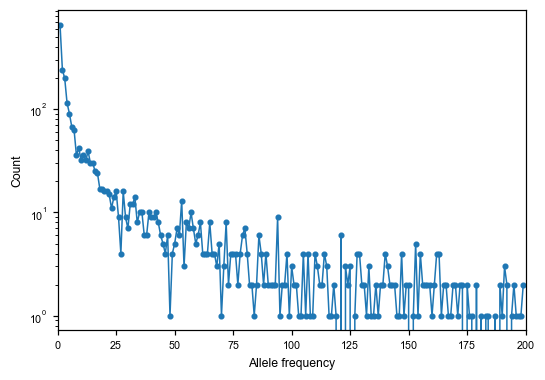

In [829]:
## create a new func that combines age-controlled SFS and returns just one spectrum to optimize
# moments.Plotting.plot_1d_fs(data)

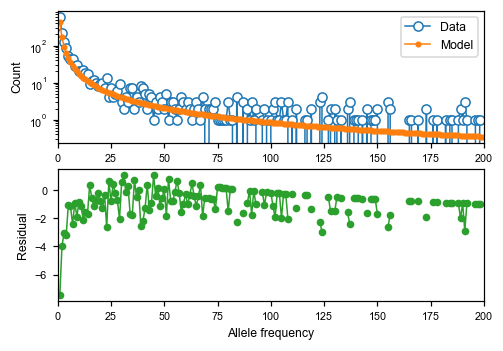

In [86]:
moments.Plotting.plot_1d_comp_Poisson(dfe_func(opt_params_mis,200,1000),data)
# moments.Spectrum(data).sum()/dfe_func(opt_params_mis,1000).sum()

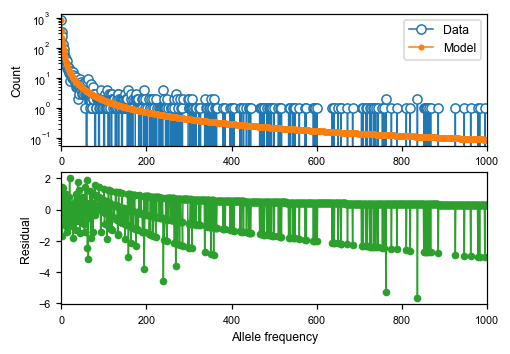

In [412]:
# moments.Plotting.plot_1d_comp_Poisson(dfe_func(opt_params_mis,1000,153),moments.Spectrum(data),residual='linear')
# moments.Plotting.plot_1d_comp_Poisson(dfe_func([0.2,200],999,234),moments.Spectrum(data),residual='linear')
# moments.Inference.ll_multinom(dfe_func(opt_params_mis,999,153),moments.Spectrum(data)), moments.Inference.ll_multinom(dfe_func([0.6,400],999,234),moments.Spectrum(data))
# plt.scatter(dfe_func(opt_params_mis,999,153), dfe_func([0.2,200],999,234), alpha=0.5); plt.xlabel('Est. SFS'); plt.ylabel('True SFS'); plt.axline((0,0),slope=1,ls='--'); plt.loglog()
# opt_theta = moments.Inference.optimal_sfs_scaling(dfe_func(opt_params_mis,999), moments.Spectrum(data)); print(opt_theta)
# opt_theta = moments.Inference.optimal_sfs_scaling(dfe_func([0.2,200],999), moments.Spectrum(data)); print(opt_theta)

In [71]:
sp.optimize.minimize(get_ll_freqchanging,x0=np.log([0.2,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':-gammas,'N0':20000,'sXlred':dat[:,5]}),bounds=((-2,0),(0,3)))
# sp.optimize.minimize(get_ll_freqagechanging,x0=[np.log(0.1),np.log(500)],method='L-BFGS-B',args=({'up_xa_s':up_xa_s,'gamma':gamma,'Nc0':10000,},dat[:,5],dat[:,3]),options={'ftol':1e-2,'gtol':1e-2})
# sp.optimize.minimize(get_ll_freqagechanging_gamma,x0=[np.log(0.5),np.log(100)],method='CG',args=({'up_xa_s':up_xa_s,'gamma':gamma,'Nc0':10000,},dat[:,5],dat[:,3]),options={'eps':1e-4,'gtol':1e-3})
# sp.optimize.fmin_bfgs(get_ll_freqchanging_gamma,x0=[np.log(0.5),np.log(500)],epsilon=1e-6,gtol=1e-2,args=({'p_xa_s':p_xa_s,'gamma':gamma,'Nc0':10000,},dat[:,5]),full_output=True,disp=True)
# sp.optimize.brute(get_ll_freqchanging_gamma, ((0.1,0.3),(100,1000)), args=({'nu':nu_func,'T':4.139,'Nc0':Nc[0],'dt_fac':0.0005,'theta':1,'numgamma':10},dat[:,5]))

      fun: 237647.14403196707
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-688.416, -328.998])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 10
     njev: 21
   status: 0
  success: True
        x: array([2.445, 1.829])

In [91]:
# sp.special.logsumexp(llage,b=wt), np.log(np.sum(wt*np.exp(llfreq)))
# plt.plot(llfreq-llfreq.max()); plt.plot(llage-llage.max()); plt.ylim((-10,0))
# plt.scatter(dat[:,5], dat[:,3])
# a1, b1 = np.log(np.linspace(0.1,0.5,2)), np.linspace(0.4,0.6,2) # -> this is the ~real deal~
# np.log(np.sum(np.exp(a1)*b1)), sp.special.logsumexp(a1,b=b1)
# llfreq, llage
# get_ll_freqchanging(np.log([1,1]),({'p_xa_s':p_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5]}))

array([0.026, 0.062, 0.082, 0.109, 0.146, 0.195, 0.259, 0.346, 0.461,
       0.615, 0.820, 1.094, 1.459, 1.946, 2.595, 3.460, 4.614, 6.153,
       8.205, 10.941, 14.591, 19.457, 25.946, 34.600, 19.773])

[]

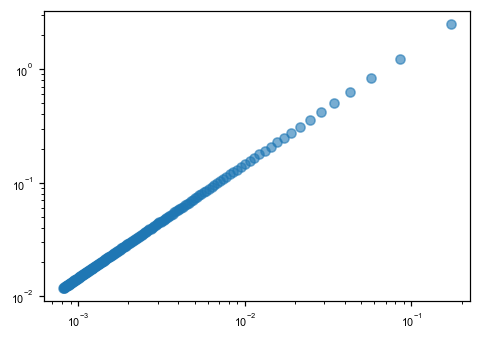

In [46]:
# fsa = np.zeros_like(up_xa_s[gamma[-1]])
# fs = np.zeros_like(p_xa_s[gamma[-1]])
# weights = sp.stats.gamma.pdf(-40000*gamma, alpha[1], scale=beta[1])
# for g, dx, w in zip(gamma, dxs, weights):
#     fs += p_xa_s[g] * dx * w
#     fsa += up_xa_s[g] * dx * w

# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();  plt.show()
# moments.Plotting.plot_1d_fs(fs)
# get_ll_xl(fs, dat[:,5]), get_ll_xl_al(fsa, dat[:,5], dat[:,2]) 
# get_ll_freqchanging([np.log(0.1),np.log(1000)],{'p_xa_s':p_xa_s,'N0':20000,'gamma':gamma,'sXlred':dat[:,5]})
# get_ll_freqagechanging(np.log([a,b]),({'up_xa_s':up_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5],'alred':dat[:,3]}))
# get_ll_freqagechanging([np.log(0.1),np.log(1000)],{'up_xa_s':up_xa_s,'N0':40000,'gamma':gamma,'sXlred':dat[:,5],'alred':dat[:,3]})

4678018.894154326

In [776]:
## inference procedure basically means integrating over different values of alpha & beta producing a certain gamma using the appropriate prior (Gamma dist)
## implement sth about weighting (dx*wt) the entire SFS instead of just the sum? and then passing it along to the optim func
alpha, beta = np.linspace(0.1,0.8,20), np.linspace(100,10000,20)
nsims = 1; theta=1
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    # df1 = pd.read_csv("outfiles/gammaHuber17Const.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=2000)
    # df1['sXl'] = df1['Xl']*1000
    # df1['al'] = 80000+1 - df1['al']
    # dat = df1.astype('int').to_numpy()
    

    # llfreq = np.array([np.sum(get_lp_xl_pois(spectrum_cache, g, dat[:,5], n=170, cutoff=1)) for g in gammas])
    # llage = np.array([np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)) for g in gamma])
    
    # dxs = ((-gamma*20000 - np.concatenate(([-gamma[0]*20000], -gamma*20000))[:-1]) / 2 + (np.concatenate((-gamma*20000, [-gamma[-1]*20000]))[1:] + gamma*20000) / 2)

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta))) 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            # weights = sp.stats.gamma.pdf(-20000*gamma, a, scale=b)
            # fsa = np.zeros_like(up_xa_s[gamma[-1]])
            # fs = np.zeros_like(p_xa_s[gamma[-1]])
            # for g, dx, w in zip(gamma, dxs, weights):
            #     fs += p_xa_s[g] * dx * w
                # fsa += up_xa_s[g] * dx * w

            # fs = theta * fs
            # fsa = theta * fsa

            # dub_onlyfreq[ia,ib] = -get_ll_freqchanging(np.log([a,b]),({'p_xa_s':p_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5]})) #get_ll_xl(fs, dat[:,5])
            dub_onlyage[ia,ib] = -get_ll_freqagechanging(np.log10([a,b]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':1}))
            # dub_onlyfreq[ia,ib] = moments.Inference.ll_multinom(dfe_func([a,b],1000,1),moments.Spectrum(data))
            # dub_onlyage[ia,ib] = sp.special.logsumexp(llage,b=wt) 

    # mlefreq.append(np.unravel_index(np.argmax(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmax(dub_onlyage,axis=None),dub_onlyage.shape))

In [873]:
# moments.Plotting.plot_1d_comp_Poisson(dfe_func([alpha[25],beta[35]],1000,150),moments.Spectrum(data))
# dub_onlyfreq

NameError: name 'dfe_func' is not defined

Text(0, 0.5, '$\\alpha$')

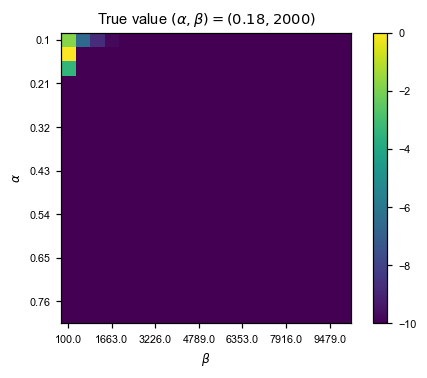

In [777]:
# plt.imshow(dub_onlyfreq-np.nanmax(dub_onlyfreq),vmin=-2); plt.title(r'True value $(\alpha,\beta)=(0.2,400)$'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.show()
plt.imshow(dub_onlyage-np.max(dub_onlyage),vmin=-10); plt.colorbar(); plt.title(r'True value $(\alpha,\beta)=(0.18,2000)$'); plt.xticks(ticks=range(0,len(beta),3),labels=np.round(beta[::3])); plt.yticks(ticks=range(0,len(beta),3),labels=np.round(alpha[::3],2)); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$')
# get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)
# ?plt.plot

In [122]:
# plt.plot(sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.1,scale=100),np.array([sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.3,scale=1000),-24757*gamma[::2]]).T);
# sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.3,scale=100)
# np.unravel_index(np.argmin(dub_onlyfreq,axis=None),dub_onlyfreq.shape)

5000.0

In [79]:
mlefreq, mleage
# (-1,-1): [-88484.88913002703, -132081.62912621396], (-10,-10): [-88457.24606171598, -132053.98605790292], (0,0): [-88432.95850947323, -132029.69850566017]
# lika1b1 = [0,0]
# for g in gamma:
#     lika1b1[0] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)) + sp.stats.gamma.logpdf(-g,alpha[0],scale=beta[0])
#     lika1b1[1] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)) + sp.stats.gamma.logpdf(-g,alpha[0],scale=beta[0])
# print(lika1b1)
# np.sum(get_lp_xl(p_xa_s, gamma[-1], dat[:,5], cutoff=1)) 

([(19, 0)], [(19, 0)])

In [383]:
## inference procedure using CDF instead of PDF (following Ortega-Del Vecchyo et al 2022 procedure)
alpha, beta = np.linspace(0.1,0.3,20), np.linspace(100,1000,20)
nsims = 2
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=1500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = 92516 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*24757
    dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta)))
    llfreq = get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1)
    llage = get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)

    tau = -150 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            wt = np.log([sp.stats.gamma.cdf(-24757*g+0.5,a,scale=b)-sp.stats.gamma.cdf(-24757*g-0.5,a,scale=b) if g>tau else 1-sp.stats.gamma.cdf(-tau+0.5,a,scale=b) for g in gamma])
            for g, w in zip(gamma, wt):
                dub_onlyfreq[ia, ib] += (llfreq + w).sum()
                dub_onlyage[ia, ib] += (llage + w).sum()

    mlefreq.append(np.unravel_index(np.argmax(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmax(dub_onlyage,axis=None),dub_onlyage.shape))